Sampled true w from truncated prior: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Sum of w_true: 1.0
All entries positive?  False


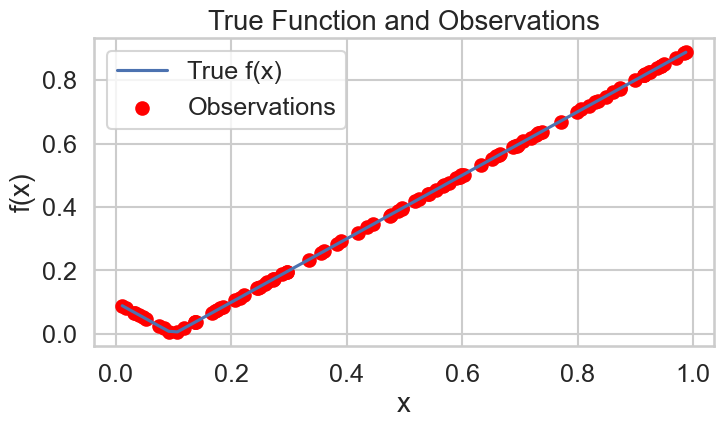

Posterior mean: [ 8.86375204e-02 -1.79522708e-01  1.06160048e-01  5.96508551e-02
 -3.69467134e-01  4.71471492e-01 -3.40528907e-02 -3.46133790e-01
  4.32280902e-01  5.75309157e-01  3.90923372e-01 -4.96390602e-02
 -4.61623305e-01  3.27847734e-01  9.73939225e-02 -1.33027194e-01
  5.38012581e-02 -1.63963256e-01  4.36904981e-01 -6.99536486e-01
  5.81356251e-01  6.27557300e-02 -4.04570529e-01 -3.90263153e-02
  3.17036513e-01 -1.22932486e-01 -1.36282818e-01  2.28414394e-01
 -1.37109573e-01  1.55558791e-02  2.92540807e-02  3.97063233e-02
  5.13545461e-02 -1.40424445e-02 -1.41372142e-01 -4.83551323e-02
  1.12222059e-01  2.49992895e-01 -2.41548416e-01 -1.06896589e-01
  2.75318986e-02  1.34292629e-01  2.45196670e-02 -1.21007661e-01
 -1.38211215e-01  1.05202636e-01  3.46054507e-01 -4.07488409e-01
  1.89858087e-01 -8.31178729e-02 -9.56673641e-03  5.17580295e-02
  4.06333944e-04 -1.03751607e-01  1.51845812e-01  2.24408284e-02
 -1.69109283e-01  5.28885177e-02  1.19375455e-01 -3.68617862e-01
  3.35424

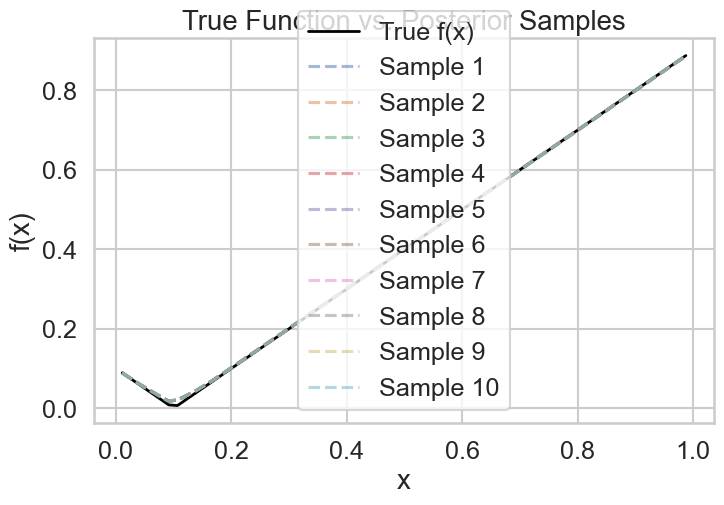

In [4]:
import numpy as np
from scipy.stats import truncnorm, multivariate_normal
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# ------------- Model and Data Generation ----------------
# Model parameters
n = 100               # number of basis functions
B = 5.0               # budget on sum of weights
T = 100               # number of observations
sigma = 0.001           # noise std

# Prior for w: mean and covariance
# Choose mu uniformly but Sigma as the identity matrix
mu = np.random.uniform(0, 1, n)
B_mu = np.random.uniform(0, 1) * B
mu = mu / np.sum(mu) * B_mu  # Normalize to sum to B
Sigma = np.eye(n) * 1.0

def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)

# Function to compute f(x) given weights w
def f(x, w):
    # t points at multiples of 1/n
    ts = np.linspace(1/n, 1, n)
    # x might be a scalar or an array; ensure it is an array
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)

# ------------- Helper Functions for Coordinate Updates ----------------

def conditional_params(i, current_w, current_mean, current_cov):
    """
    Compute the conditional distribution parameters for coordinate i,
    given the other coordinates in current_w for a Gaussian with mean current_mean
    and covariance current_cov.
    Returns (m_cond, var_cond).
    """
    idx = i
    other_idx = [j for j in range(len(current_w)) if j != i]
    
    Sigma_ii = current_cov[idx, idx]
    Sigma_i_other = current_cov[idx, other_idx]
    Sigma_other_other = current_cov[np.ix_(other_idx, other_idx)]
    
    mean_i = current_mean[idx]
    mean_other = current_mean[other_idx]
    
    inv_Sigma_other_other = np.linalg.inv(Sigma_other_other)
    
    m_cond = mean_i + Sigma_i_other @ inv_Sigma_other_other @ (current_w[other_idx] - mean_other)
    var_cond = Sigma_ii - Sigma_i_other @ inv_Sigma_other_other @ Sigma_i_other.T
    return m_cond, var_cond

def sample_conditional(i, current_w, current_mean, current_cov, B):
    """
    Sample a new value for coordinate i from its conditional distribution,
    truncated to [0, B - sum_{j != i} current_w[j]].
    """
    m_cond, var_cond = conditional_params(i, current_w, current_mean, current_cov)
    sd_cond = np.sqrt(var_cond)
    
    # Constraint: w_i must be > 0, and also we must have sum(w) <= B.
    sum_others = np.sum(np.delete(current_w, i))
    lower = 0.0
    upper = B - sum_others
    
    # In case numerical issues arise
    if upper < lower:
        upper = lower

    a, b = (lower - m_cond) / sd_cond, (upper - m_cond) / sd_cond
    new_val = truncnorm.rvs(a, b, loc=m_cond, scale=sd_cond)
    return new_val

def coordinate_hit_and_run(current_mean, current_cov, B, num_samples=1000, burn_in=500, init=None):
    """
    Run a coordinate-wise hit-and-run sampler for a Gaussian with given mean and covariance,
    truncated to the region {w: w_i > 0 for all i, sum(w) <= B}.
    Returns samples of shape (num_samples, n).
    """
    n = len(current_mean)
    # Initialize the chain. If no initial point is given, use the current_mean projected into the region.
    if init is None:
        init = np.copy(current_mean)
        init[init <= 0] = 1e-3
        if np.sum(init) > B:
            init = init * (B / np.sum(init))
    current_w = np.copy(init)
    samples = []
    total_iters = burn_in + num_samples
    for it in range(total_iters):
        # Randomly choose a coordinate to update
        i = np.random.randint(n)
        current_w[i] = sample_conditional(i, current_w, current_mean, current_cov, B)
        if it >= burn_in:
            samples.append(np.copy(current_w))
    return np.array(samples)

# ------------- Sampling f* from the Prior using Hit-and-Run ----------------

# Instead of rejection sampling, use the coordinate sampler to obtain one sample from the truncated prior.
prior_samples = coordinate_hit_and_run(mu, Sigma, B, num_samples=1, burn_in=500)
w_true = prior_samples[0]

# Tweaking the true function for testing purposes
w_true = np.eye(n)[9]

print("Sampled true w from truncated prior:", w_true)
print("Sum of w_true:", np.sum(w_true))
print("All entries positive? ", np.all(w_true > 0))

# ------------- Generate Observations ----------------
# Generate T observations: choose x uniformly in [0,1]
xs = np.sort(np.random.uniform(0, 1, T))
# Compute true function values without noise
f_true = f(xs, w_true)
# Observations with Gaussian noise
ys = f_true + np.random.normal(0, sigma, size=T)

# Plot the true function and data
plt.figure(figsize=(8, 4))
plt.plot(xs, f_true, label="True f(x)")
plt.scatter(xs, ys, color='red', label="Observations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("True Function and Observations")
plt.show()

# ------------- Posterior Computation ----------------
# Build design matrix Phi: Phi[i,t] = |x_i - t| for t equally spaced in [0,1].
ts = np.linspace(1/n, 1, n)
Phi = np.array([[np.abs(x - t) for t in ts] for x in xs])

# Compute posterior covariance and mean:
Sigma_inv = np.linalg.inv(Sigma)
post_cov_inv = Sigma_inv + (Phi.T @ Phi) / (sigma**2)
post_cov = np.linalg.inv(post_cov_inv)
post_mean = post_cov @ (Sigma_inv @ mu + (Phi.T @ ys) / (sigma**2))

print("Posterior mean:", post_mean)
print("Posterior covariance diagonal:", np.diag(post_cov))

# ------------- Sampling from the Posterior with Coordinate Hit-and-Run ----------------

posterior_samples = coordinate_hit_and_run(post_mean, post_cov, B, num_samples=10, burn_in=5000)

# ------------- Plot 10 Sampled Functions ----------------
# Create a dense grid of x-values in [0,1]
x_grid = np.linspace(0, 1, 200)

# Randomly select 10 posterior samples
sample_indices = np.random.choice(posterior_samples.shape[0], size=10, replace=False)

plt.figure(figsize=(8, 5))

# Plot the true function
plt.plot(xs, f_true, label="True f(x)", color='black', linewidth=2)

# Select 10 random samples from the posterior
num_funcs_to_plot = 10
sample_indices = np.random.choice(len(posterior_samples), num_funcs_to_plot, replace=False)

for idx in sample_indices:
    w_sample = posterior_samples[idx]
    f_sample = f(xs, w_sample)
    plt.plot(xs, f_sample, alpha=0.5, linestyle='dashed')

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("True Function vs. Posterior Samples")
plt.legend(["True f(x)"] + [f"Sample {i+1}" for i in range(num_funcs_to_plot)])
plt.show()


Sampled true w from truncated prior: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

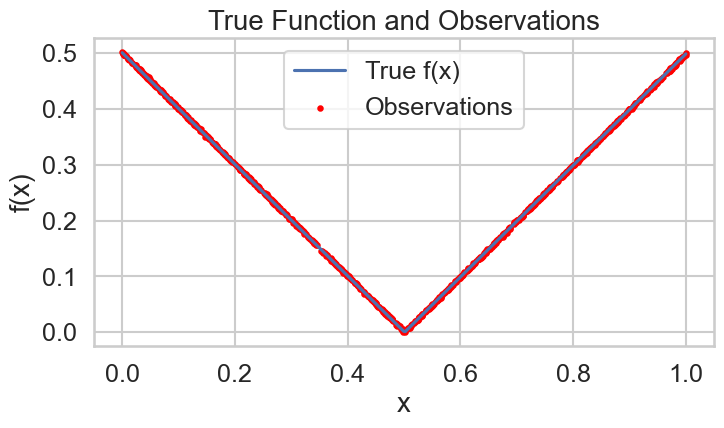

Posterior mean: [-3.28915690e-01 -1.67824952e-01  9.62099481e-01 -3.66873779e-01
 -1.23172261e-01  2.01091717e-01 -2.65406786e-01 -1.42558755e-01
 -3.98709627e-02  1.17986004e-01  5.67963239e-01 -1.45469407e-01
 -1.65515353e-01 -1.85929491e-01 -9.89542439e-02 -4.02711252e-02
  1.93494681e-02  1.58944544e-01  1.02349638e-01  7.35791190e-02
  2.14222861e-02 -3.72114950e-03 -2.27837117e-03 -4.93388267e-01
  1.93335626e-01  1.17495825e-01 -2.56742955e-01  1.59137249e-01
  5.88307752e-01 -4.57283848e-01  2.15116698e-01 -4.02307295e-02
 -1.52637044e-01 -3.10393195e-01  3.06893877e-01 -1.85321632e-01
  1.23810513e-01  2.86062594e-01  2.12613738e-02 -2.55283011e-01
 -1.85362594e-01  4.13591389e-01 -4.11417876e-01 -2.61724771e-01
  2.78195546e-01  7.98699295e-01  1.22983757e-01 -1.24686658e+00
  2.75683320e-01 -1.78785097e-02  5.78084469e-02  8.82701975e-02
  6.47684365e-02  2.19286784e-01 -1.81090846e-01 -5.46275794e-01
  4.95706679e-01  6.32327232e-01 -7.30168395e-01 -6.14740492e-02
  4.94582

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy.stats import truncnorm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# ------------- Model and Data Generation ----------------
# Model parameters
n = 100               # number of basis functions
B = 5.0               # budget on sum of weights
T = 100              # number of observations
sigma = 0.001          # noise std

# Prior for w: mean and covariance
# Choose mu uniformly but Sigma as the identity matrix
mu = np.random.uniform(0, 1, n)
B_mu = np.random.uniform(0, 1) * B
mu = mu / np.sum(mu) * B_mu  # Normalize to sum to B
Sigma = np.eye(n) * 1.0

def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)

# Function to compute f(x) given weights w
def f(x, w):
    # t points at multiples of 1/n
    ts = np.linspace(1/n, 1, n)
    # x might be a scalar or an array; ensure it is an array
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)

# ------------- Helper Functions for Coordinate Updates ----------------

def conditional_params(i, current_w, current_mean, current_cov):
    """
    Compute the conditional distribution parameters for coordinate i,
    given the other coordinates in current_w for a Gaussian with mean current_mean
    and covariance current_cov.
    Returns (m_cond, var_cond).
    """
    idx = i
    other_idx = [j for j in range(len(current_w)) if j != i]
    
    Sigma_ii = current_cov[idx, idx]
    Sigma_i_other = current_cov[idx, other_idx]
    Sigma_other_other = current_cov[np.ix_(other_idx, other_idx)]
    
    mean_i = current_mean[idx]
    mean_other = current_mean[other_idx]
    
    inv_Sigma_other_other = np.linalg.inv(Sigma_other_other)
    
    m_cond = mean_i + Sigma_i_other @ inv_Sigma_other_other @ (current_w[other_idx] - mean_other)
    var_cond = Sigma_ii - Sigma_i_other @ inv_Sigma_other_other @ Sigma_i_other.T
    return m_cond, var_cond

def sample_conditional(i, current_w, current_mean, current_cov, B):
    """
    Sample a new value for coordinate i from its conditional distribution,
    truncated to [0, B - sum_{j != i} current_w[j]].
    """
    m_cond, var_cond = conditional_params(i, current_w, current_mean, current_cov)
    sd_cond = np.sqrt(var_cond)
    
    # Constraint: w_i must be > 0, and also we must have sum(w) <= B.
    sum_others = np.sum(np.delete(current_w, i))
    lower = 0.0
    upper = B - sum_others
    
    # In case numerical issues arise
    if upper < lower:
        upper = lower

    a, b = (lower - m_cond) / sd_cond, (upper - m_cond) / sd_cond
    new_val = truncnorm.rvs(a, b, loc=m_cond, scale=sd_cond)
    return new_val

def coordinate_hit_and_run(current_mean, current_cov, B, num_samples=1000, burn_in=500, init=None):
    """
    Run a coordinate-wise hit-and-run (i.e. Gibbs) sampler for a Gaussian with given mean and covariance,
    truncated to the region {w: w_i > 0 for all i, sum(w) <= B}.
    Returns samples of shape (num_samples, n).
    """
    n = len(current_mean)
    # Initialize the chain. If no initial point is given, use the current_mean projected into the region.
    if init is None:
        init = np.copy(current_mean)
        init[init <= 0] = 1e-3
        if np.sum(init) > B:
            init = init * (B / np.sum(init))
    current_w = np.copy(init)
    samples = []
    total_iters = burn_in + num_samples
    for it in range(total_iters):
        # Randomly choose a coordinate to update
        i = np.random.randint(n)
        current_w[i] = sample_conditional(i, current_w, current_mean, current_cov, B)
        if it >= burn_in:
            samples.append(np.copy(current_w))
    return np.array(samples)

# ------------- New Helper Functions for Directional Hit-and-Run ----------------

def compute_line_interval(w, d, B):
    """
    Given a current point w and a direction d, compute the maximum interval [t_lower, t_upper]
    such that for all t in this interval, the linear constraints hold:
        (i)  For each coordinate: w[i] + t*d[i] >= 0.
        (ii) The sum constraint: sum(w) + t * sum(d) <= B.
    """
    lower_candidates = []
    upper_candidates = []
    # Coordinate-wise constraints:
    for i in range(len(w)):
        if d[i] > 0:
            # w[i] + t*d[i] >= 0  =>  t >= -w[i]/d[i]
            lower_candidates.append(-w[i] / d[i])
        elif d[i] < 0:
            # w[i] + t*d[i] >= 0  =>  t <= -w[i]/d[i]
            upper_candidates.append(-w[i] / d[i])
        # If d[i] == 0, no constraint from coordinate i.
    # Sum constraint: sum(w) + t * sum(d) <= B.
    S = np.sum(w)
    D = np.sum(d)
    if D > 0:
        upper_candidates.append((B - S) / D)
    elif D < 0:
        lower_candidates.append((B - S) / D)
    # Determine overall t_lower and t_upper.
    t_lower = max(lower_candidates) if lower_candidates else -np.inf
    t_upper = min(upper_candidates) if upper_candidates else np.inf
    return t_lower, t_upper

def directional_hit_and_run(post_mean, post_cov, B, num_samples=1000, burn_in=500, init=None):
    """
    Run a directional hit-and-run sampler for a Gaussian with given mean and covariance,
    truncated to the region {w: w_i > 0 for all i, sum(w) <= B}.
    
    At each iteration:
      - Sample a random direction d (uniformly on the unit sphere).
      - Compute the line segment (i.e. the range of t) along which the constraints hold.
      - Compute the one-dimensional conditional distribution along the line.
        (Because the target is Gaussian, the density along the line is a truncated univariate Gaussian.)
      - Sample t from that distribution and update: new_w = current_w + t*d.
    
    Returns samples of shape (num_samples, n).
    """
    n = len(post_mean)
    # For convenience, compute the inverse covariance (precision) for the posterior.
    post_cov_inv = np.linalg.inv(post_cov)
    
    # Initialize the chain.
    if init is None:
        init = np.copy(post_mean)
        init[init <= 0] = 1e-3
        if np.sum(init) > B:
            init = init * (B / np.sum(init))
    current_w = np.copy(init)
    samples = []
    total_iters = burn_in + num_samples
    for it in range(total_iters):
        # Sample a random direction uniformly on the unit sphere.
        d = np.random.randn(n)
        d = d / np.linalg.norm(d)
        
        # Compute the interval for t such that w_new = current_w + t*d remains feasible.
        t_lower, t_upper = compute_line_interval(current_w, d, B)
        if t_lower > t_upper:
            # In case of numerical issues (should rarely happen), skip this update.
            continue
        
        # The target density is Gaussian: 
        #    p(w) ∝ exp{ -1/2 (w - post_mean)^T post_cov_inv (w - post_mean) }.
        # Along the line: let w = current_w + t*d, then writing v = current_w - post_mean,
        # we have:
        #    p(t) ∝ exp{ -1/2 [ t^2 (d^T post_cov_inv d) + 2t (d^T post_cov_inv v) + constant ] }.
        # Hence t|w follows a univariate Gaussian with:
        q_val = d.T @ post_cov_inv @ d  # precision along the direction
        v = current_w - post_mean
        c_val = d.T @ post_cov_inv @ v
        t_mean = - c_val / q_val
        t_std = np.sqrt(1.0 / q_val)
        
        # Sample t from a truncated normal on [t_lower, t_upper].
        a, b = (t_lower - t_mean) / t_std, (t_upper - t_mean) / t_std
        t_sample = truncnorm.rvs(a, b, loc=t_mean, scale=t_std)
        
        # Update current_w along the direction d.
        current_w = current_w + t_sample * d
        if it >= burn_in:
            samples.append(np.copy(current_w))
    return np.array(samples)

def sample_posterior(post_mean, post_cov, B, num_samples=1000, burn_in=500, init=None, sampler_type='coordinate'):
    """
    Choose between the coordinate-wise and directional hit-and-run samplers.
    
    sampler_type: 'coordinate' or 'directional'
    """
    if sampler_type == 'coordinate':
        return coordinate_hit_and_run(post_mean, post_cov, B, num_samples, burn_in, init)
    elif sampler_type == 'directional':
        return directional_hit_and_run(post_mean, post_cov, B, num_samples, burn_in, init)
    else:
        raise ValueError("Unknown sampler_type. Choose either 'coordinate' or 'directional'.")

# ------------- Sampling f* from the Prior using Hit-and-Run ----------------

# Instead of rejection sampling, use the coordinate sampler to obtain one sample from the truncated prior.
prior_samples = coordinate_hit_and_run(mu, Sigma, B, num_samples=1, burn_in=500)
w_true = prior_samples[0]

# Tweaking the true function for testing purposes
w_true = np.eye(n)[n//2]  # here we override the sampled weight for testing

print("Sampled true w from truncated prior:", w_true)
print("Sum of w_true:", np.sum(w_true))
print("All entries positive? ", np.all(w_true > 0))

# ------------- Generate Observations ----------------
# Generate T observations: choose x uniformly in [0,1]
xs = np.sort(np.random.uniform(0, 1, T))
# Compute true function values without noise
f_true = f(xs, w_true)
# Observations with Gaussian noise
ys = f_true + np.random.normal(0, sigma, size=T)

# Plot the true function and data
plt.figure(figsize=(8, 4))
plt.plot(xs, f_true, label="True f(x)")
plt.scatter(xs, ys, color='red', label="Observations", s=10)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("True Function and Observations")
plt.show()

# ------------- Posterior Computation ----------------
# Build design matrix Phi: Phi[i,t] = |x_i - t| for t equally spaced in [0,1].
ts = np.linspace(1/n, 1, n)
Phi = np.array([[np.abs(x - t) for t in ts] for x in xs])

# Compute posterior covariance and mean:
Sigma_inv = np.linalg.inv(Sigma)
post_cov_inv = Sigma_inv + (Phi.T @ Phi) / (sigma**2)
post_cov = np.linalg.inv(post_cov_inv)
post_mean = post_cov @ (Sigma_inv @ mu + (Phi.T @ ys) / (sigma**2))

print("Posterior mean:", post_mean)
print("Posterior covariance diagonal:", np.diag(post_cov))

# ------------- Sampling from the Posterior ----------------
# Choose the sampler type: either 'coordinate' or 'directional'
# sampler_type = 'directional'  # change to 'coordinate' to use the coordinate sampler
sampler_type = 'coordinate'  # change to 'coordinate' to use the coordinate sampler
posterior_samples_coor = sample_posterior(post_mean, post_cov, B, num_samples=10, burn_in=5000, sampler_type=sampler_type)

# ------------- Plot 10 Sampled Functions ----------------
# Use a seaborn style for prettier plots
sns.set(style="whitegrid", context="talk", font_scale=1.1)

# ------------- Plot: True Function and Observations ----------------

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(xs, f_true, label="True f(x)", color="blue", linewidth=2)
plt.scatter(xs, ys, label="Observations", color="orange", edgecolor="k", s=40, alpha=0.8)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("True Function and Observations")
plt.legend()
plt.tight_layout()
plt.show()


# ------------- Plot: True Function vs. Posterior Samples ----------------

plt.figure(figsize=(10, 6), dpi=100)
# Plot the true function as a bold, solid line.
plt.plot(xs, f_true, label="True f(x)", color="black", linewidth=2)

# Plot a few posterior sample functions using a colormap.
num_funcs_to_plot = 10
sample_indices = np.random.choice(len(posterior_samples), num_funcs_to_plot, replace=False)
colors = plt.cm.viridis(np.linspace(0, 1, num_funcs_to_plot))

for idx, col in zip(sample_indices, colors):
    w_sample = posterior_samples[idx]
    f_sample = f(xs, w_sample)
    plt.plot(xs, f_sample, linestyle="--", linewidth=1.5, alpha=0.8, color=col,
             label=f"Sample {idx}")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(f"True Function vs. Posterior Samples ({sampler_type.capitalize()} Hit-and-Run)")
# Create a legend that only shows the True f(x) once; the sample lines can be grouped.
plt.legend(["True f(x)"] + [f"Sample {i+1}" for i in range(num_funcs_to_plot)], loc="best")
plt.tight_layout()
plt.show()


Sampled true w from truncated prior: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Sum of w_true: 1.0
All entries positive?  False


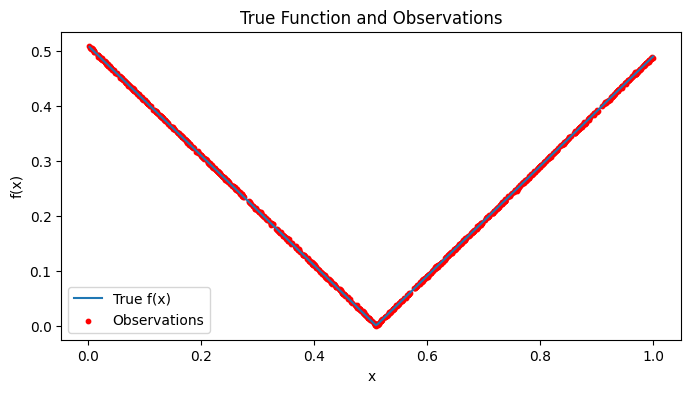

Posterior mean: [-6.98939526e-02  9.85206690e-02 -4.28953426e-02  6.17987837e-03
  2.67677200e-02 -3.46586696e-02  2.89018242e-02  1.09827555e-02
 -2.76985111e-02 -1.96366155e-02  2.46238550e-02  2.52831738e-02
 -3.57154487e-02 -1.01269941e-02  4.84364916e-02 -2.99135925e-02
 -3.32087155e-02  5.29723216e-02 -1.30673944e-02  1.08922969e-02
 -6.38268332e-02  8.40863253e-02 -6.72576585e-02  6.37564660e-02
 -2.38002774e-02 -2.92851140e-02  3.65182294e-02 -2.62786287e-02
 -3.86959473e-02  1.05695730e-01 -1.06168799e-01  1.02490370e-01
 -1.10458994e-01  1.10690986e-01 -8.33355647e-02  6.03598632e-02
 -6.70163197e-02  4.07586781e-02  3.23636970e-03 -2.93529355e-02
  2.57516345e-02  6.45430060e-04  4.71287721e-03  5.44733659e-03
 -2.45850174e-02 -2.37882143e-02  9.56270841e-02 -6.92519109e-02
 -1.32795016e-02 -3.36302689e-03  1.04582872e+00 -4.31567726e-02
  3.57562024e-02  1.49251259e-03 -4.05308502e-02  1.64452383e-02
  2.77519344e-02  9.26504249e-03 -9.37074927e-02  1.01895338e-01
 -3.66134

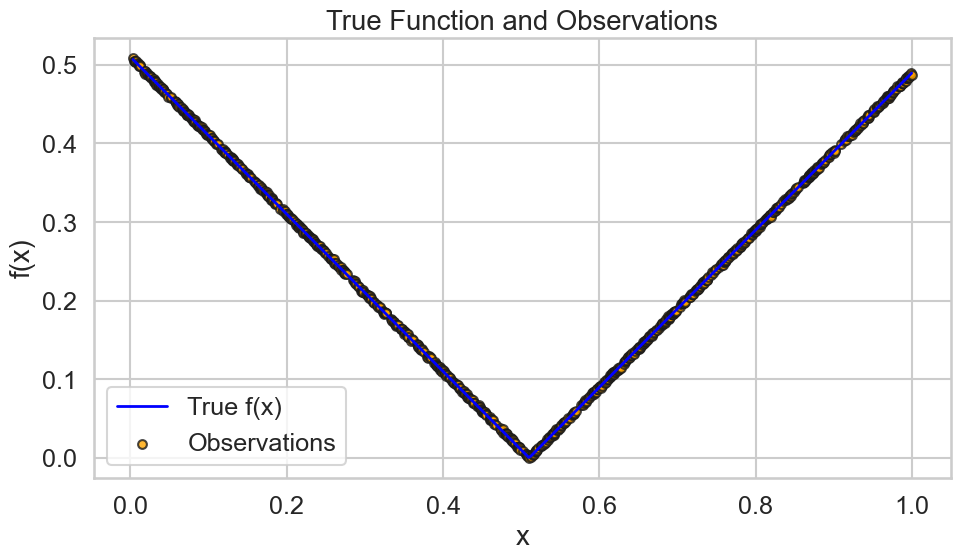

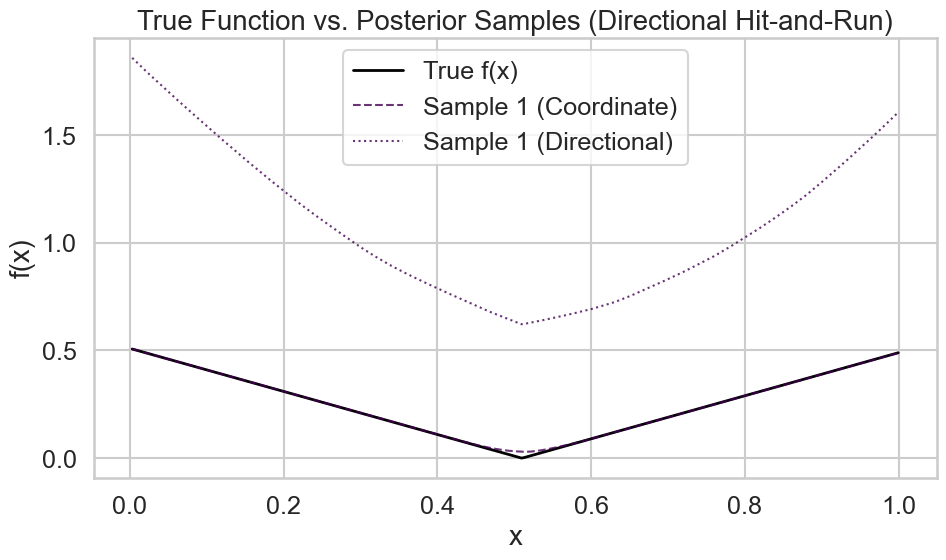

In [2]:
import numpy as np
from scipy.stats import truncnorm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# ------------- Model and Data Generation ----------------
# Model parameters
n = 100               # number of basis functions
B = 5.0               # budget on sum of weights
T = 1000              # number of observations
sigma = 0.001          # noise std

# Prior for w: mean and covariance
# Choose mu uniformly but Sigma as the identity matrix
mu = np.random.uniform(0, 1, n)
B_mu = np.random.uniform(0, 1) * B
mu = mu / np.sum(mu) * B_mu  # Normalize to sum to B
Sigma = np.eye(n) * 1.0

def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)

# Function to compute f(x) given weights w
def f(x, w):
    # t points at multiples of 1/n
    ts = np.linspace(1/n, 1, n)
    # x might be a scalar or an array; ensure it is an array
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)

# ------------- Helper Functions for Coordinate Updates ----------------

def conditional_params(i, current_w, current_mean, current_cov):
    """
    Compute the conditional distribution parameters for coordinate i,
    given the other coordinates in current_w for a Gaussian with mean current_mean
    and covariance current_cov.
    Returns (m_cond, var_cond).
    """
    idx = i
    other_idx = [j for j in range(len(current_w)) if j != i]
    
    Sigma_ii = current_cov[idx, idx]
    Sigma_i_other = current_cov[idx, other_idx]
    Sigma_other_other = current_cov[np.ix_(other_idx, other_idx)]
    
    mean_i = current_mean[idx]
    mean_other = current_mean[other_idx]
    
    inv_Sigma_other_other = np.linalg.inv(Sigma_other_other)
    
    m_cond = mean_i + Sigma_i_other @ inv_Sigma_other_other @ (current_w[other_idx] - mean_other)
    var_cond = Sigma_ii - Sigma_i_other @ inv_Sigma_other_other @ Sigma_i_other.T
    return m_cond, var_cond

def sample_conditional(i, current_w, current_mean, current_cov, B):
    """
    Sample a new value for coordinate i from its conditional distribution,
    truncated to [0, B - sum_{j != i} current_w[j]].
    """
    m_cond, var_cond = conditional_params(i, current_w, current_mean, current_cov)
    sd_cond = np.sqrt(var_cond)
    
    # Constraint: w_i must be > 0, and also we must have sum(w) <= B.
    sum_others = np.sum(np.delete(current_w, i))
    lower = 0.0
    upper = B - sum_others
    
    # In case numerical issues arise
    if upper < lower:
        upper = lower

    a, b = (lower - m_cond) / sd_cond, (upper - m_cond) / sd_cond
    new_val = truncnorm.rvs(a, b, loc=m_cond, scale=sd_cond)
    return new_val

def coordinate_hit_and_run(current_mean, current_cov, B, num_samples=1000, burn_in=500, init=None):
    """
    Run a coordinate-wise hit-and-run (i.e. Gibbs) sampler for a Gaussian with given mean and covariance,
    truncated to the region {w: w_i > 0 for all i, sum(w) <= B}.
    Returns samples of shape (num_samples, n).
    """
    n = len(current_mean)
    # Initialize the chain. If no initial point is given, use the current_mean projected into the region.
    if init is None:
        init = np.copy(current_mean)
        init[init <= 0] = 1e-3
        if np.sum(init) > B:
            init = init * (B / np.sum(init))
    current_w = np.copy(init)
    samples = []
    total_iters = burn_in + num_samples
    for it in range(total_iters):
        # Randomly choose a coordinate to update
        i = np.random.randint(n)
        current_w[i] = sample_conditional(i, current_w, current_mean, current_cov, B)
        if it >= burn_in:
            samples.append(np.copy(current_w))
    return np.array(samples)

# ------------- New Helper Functions for Directional Hit-and-Run ----------------

def compute_line_interval(w, d, B):
    """
    Given a current point w and a direction d, compute the maximum interval [t_lower, t_upper]
    such that for all t in this interval, the linear constraints hold:
        (i)  For each coordinate: w[i] + t*d[i] >= 0.
        (ii) The sum constraint: sum(w) + t * sum(d) <= B.
    """
    lower_candidates = []
    upper_candidates = []
    # Coordinate-wise constraints:
    for i in range(len(w)):
        if d[i] > 0:
            # w[i] + t*d[i] >= 0  =>  t >= -w[i]/d[i]
            lower_candidates.append(-w[i] / d[i])
        elif d[i] < 0:
            # w[i] + t*d[i] >= 0  =>  t <= -w[i]/d[i]
            upper_candidates.append(-w[i] / d[i])
        # If d[i] == 0, no constraint from coordinate i.
    # Sum constraint: sum(w) + t * sum(d) <= B.
    S = np.sum(w)
    D = np.sum(d)
    if D > 0:
        upper_candidates.append((B - S) / D)
    elif D < 0:
        lower_candidates.append((B - S) / D)
    # Determine overall t_lower and t_upper.
    t_lower = max(lower_candidates) if lower_candidates else -np.inf
    t_upper = min(upper_candidates) if upper_candidates else np.inf
    return t_lower, t_upper

def directional_hit_and_run(post_mean, post_cov, B, num_samples=1000, burn_in=500, init=None):
    """
    Run a directional hit-and-run sampler for a Gaussian with given mean and covariance,
    truncated to the region {w: w_i > 0 for all i, sum(w) <= B}.
    
    At each iteration:
      - Sample a random direction d (uniformly on the unit sphere).
      - Compute the line segment (i.e. the range of t) along which the constraints hold.
      - Compute the one-dimensional conditional distribution along the line.
        (Because the target is Gaussian, the density along the line is a truncated univariate Gaussian.)
      - Sample t from that distribution and update: new_w = current_w + t*d.
    
    Returns samples of shape (num_samples, n).
    """
    n = len(post_mean)
    # For convenience, compute the inverse covariance (precision) for the posterior.
    post_cov_inv = np.linalg.inv(post_cov)
    
    # Initialize the chain.
    if init is None:
        init = np.copy(post_mean)
        init[init <= 0] = 1e-3
        if np.sum(init) > B:
            init = init * (B / np.sum(init))
    current_w = np.copy(init)
    samples = []
    total_iters = burn_in + num_samples
    for it in range(total_iters):
        # Sample a random direction uniformly on the unit sphere.
        d = np.random.randn(n)
        d = d / np.linalg.norm(d)
        
        # Compute the interval for t such that w_new = current_w + t*d remains feasible.
        t_lower, t_upper = compute_line_interval(current_w, d, B)
        if t_lower > t_upper:
            # In case of numerical issues (should rarely happen), skip this update.
            continue
        
        # The target density is Gaussian: 
        #    p(w) ∝ exp{ -1/2 (w - post_mean)^T post_cov_inv (w - post_mean) }.
        # Along the line: let w = current_w + t*d, then writing v = current_w - post_mean,
        # we have:
        #    p(t) ∝ exp{ -1/2 [ t^2 (d^T post_cov_inv d) + 2t (d^T post_cov_inv v) + constant ] }.
        # Hence t|w follows a univariate Gaussian with:
        q_val = d.T @ post_cov_inv @ d  # precision along the direction
        v = current_w - post_mean
        c_val = d.T @ post_cov_inv @ v
        t_mean = - c_val / q_val
        t_std = np.sqrt(1.0 / q_val)
        
        # Sample t from a truncated normal on [t_lower, t_upper].
        a, b = (t_lower - t_mean) / t_std, (t_upper - t_mean) / t_std
        t_sample = truncnorm.rvs(a, b, loc=t_mean, scale=t_std)
        
        # Update current_w along the direction d.
        current_w = current_w + t_sample * d
        if it >= burn_in:
            samples.append(np.copy(current_w))
    return np.array(samples)

def sample_posterior(post_mean, post_cov, B, num_samples=1000, burn_in=500, init=None, sampler_type='coordinate'):
    """
    Choose between the coordinate-wise and directional hit-and-run samplers.
    
    sampler_type: 'coordinate' or 'directional'
    """
    if sampler_type == 'coordinate':
        return coordinate_hit_and_run(post_mean, post_cov, B, num_samples, burn_in, init)
    elif sampler_type == 'directional':
        return directional_hit_and_run(post_mean, post_cov, B, num_samples, burn_in, init)
    else:
        raise ValueError("Unknown sampler_type. Choose either 'coordinate' or 'directional'.")

# ------------- Sampling f* from the Prior using Hit-and-Run ----------------

# Instead of rejection sampling, use the coordinate sampler to obtain one sample from the truncated prior.
prior_samples = coordinate_hit_and_run(mu, Sigma, B, num_samples=1, burn_in=500)
w_true = prior_samples[0]

# Tweaking the true function for testing purposes
w_true = np.eye(n)[n//2]  # here we override the sampled weight for testing

print("Sampled true w from truncated prior:", w_true)
print("Sum of w_true:", np.sum(w_true))
print("All entries positive? ", np.all(w_true > 0))

# ------------- Generate Observations ----------------
# Generate T observations: choose x uniformly in [0,1]
xs = np.sort(np.random.uniform(0, 1, T))
# Compute true function values without noise
f_true = f(xs, w_true)
# Observations with Gaussian noise
ys = f_true + np.random.normal(0, sigma, size=T)

# Plot the true function and data
plt.figure(figsize=(8, 4))
plt.plot(xs, f_true, label="True f(x)")
plt.scatter(xs, ys, color='red', label="Observations", s=10)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("True Function and Observations")
plt.show()

# ------------- Posterior Computation ----------------
# Build design matrix Phi: Phi[i,t] = |x_i - t| for t equally spaced in [0,1].
ts = np.linspace(1/n, 1, n)
Phi = np.array([[np.abs(x - t) for t in ts] for x in xs])

# Compute posterior covariance and mean:
Sigma_inv = np.linalg.inv(Sigma)
post_cov_inv = Sigma_inv + (Phi.T @ Phi) / (sigma**2)
post_cov = np.linalg.inv(post_cov_inv)
post_mean = post_cov @ (Sigma_inv @ mu + (Phi.T @ ys) / (sigma**2))

print("Posterior mean:", post_mean)
print("Posterior covariance diagonal:", np.diag(post_cov))

# ------------- Sampling from the Posterior ----------------
# Choose the sampler type: either 'coordinate' or 'directional'
# sampler_type = 'directional'  # change to 'coordinate' to use the coordinate sampler
sampler_type = 'coordinate'  # change to 'coordinate' to use the coordinate sampler
posterior_samples_coor = sample_posterior(post_mean, post_cov, B, num_samples=1, burn_in=5000, sampler_type=sampler_type)

sampler_type = 'directional'  # change to 'coordinate' to use the coordinate sampler
posterior_samples_dirc = sample_posterior(post_mean, post_cov, B, num_samples=1, burn_in=5000, sampler_type=sampler_type)

# ------------- Plot 1 Sampled Functions from each Sampler ----------------
# Use a seaborn style for prettier plots
sns.set(style="whitegrid", context="talk", font_scale=1.1)

# ------------- Plot: True Function and Observations ----------------

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(xs, f_true, label="True f(x)", color="blue", linewidth=2)
plt.scatter(xs, ys, label="Observations", color="orange", edgecolor="k", s=40, alpha=0.8)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("True Function and Observations")
plt.legend()
plt.tight_layout()


# ------------- Plot: True Function vs. Posterior Samples from each algorithm ----------------

plt.figure(figsize=(10, 6), dpi=100)
# Plot the true function as a bold, solid line.
plt.plot(xs, f_true, label="True f(x)", color="black", linewidth=2)

# Plot a few posterior sample functions using a colormap.
num_funcs_to_plot = 1
sample_indices = np.random.choice(len(posterior_samples_coor), num_funcs_to_plot, replace=False)
colors = plt.cm.viridis(np.linspace(0, 1, num_funcs_to_plot))

for idx, col in zip(sample_indices, colors):
    w_sample = posterior_samples_coor[idx]
    f_sample = f(xs, w_sample)
    plt.plot(xs, f_sample, linestyle="--", linewidth=1.5, alpha=0.8, color=col,
             label=f"Sample {idx} (Coordinate)")

sample_indices = np.random.choice(len(posterior_samples_dirc), num_funcs_to_plot, replace=False)
colors = plt.cm.viridis(np.linspace(0, 1, num_funcs_to_plot))

for idx, col in zip(sample_indices, colors):
    w_sample = posterior_samples_dirc[idx]
    f_sample = f(xs, w_sample)
    plt.plot(xs, f_sample, linestyle="dotted", linewidth=1.5, alpha=0.8, color=col,
             label=f"Sample {idx} (Directional)")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(f"True Function vs. Posterior Samples ({sampler_type.capitalize()} Hit-and-Run)")
# Create a legend that only shows the True f(x) once; the sample lines can be grouped.
plt.legend(["True f(x)"] + [f"Sample {i+1} (Coordinate)" for i in range(num_funcs_to_plot)] + 
           [f"Sample {i+1} (Directional)" for i in range(num_funcs_to_plot)], loc="best")
plt.tight_layout()
plt.show()
